## Jordi Blasco Lozano  
### Generación de grafos matcheados – Parte 2

- #### Librerías y Configuración Inicial

    En este bloque se importan las librerías necesarias para la visualización, generación de grafos, generación de triangulaciones y matcheos

    También se importa el módulo **DataLoader** para cargar nuestro dataset de paths.

In [1]:

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import random
import logging
import matplotlib.colors as mcolors
import random

from tqdm.notebook import tqdm
from gensim.models import Word2Vec
from scipy.optimize import linear_sum_assignment
from scipy.spatial import Delaunay, distance
from PIL import Image

from archivos.dataloader import DataLoader



- #### Configuración del logger
    En esta practica usaremos también la librería logging para generar la información de depuración, usaremos en livel de log de info para que en el momento de ejecución del programa sepamos que está haciendo nuestro programa en todo momento.

In [2]:
logging.getLogger('gensim').setLevel(logging.WARNING)
logging.basicConfig(level=logging.INFO,
                    format='[%(asctime)s] %(levelname)s: %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S')
logger = logging.getLogger(__name__)
logger.info(f'Logging level: {logging.getLevelName(logger.getEffectiveLevel())}')


[2025-03-04 11:47:34] INFO: Logging level: INFO


- #### Carga del Dataset

In [3]:
# Instanciar el DataLoader y cargar los dataframes

dl = DataLoader()
dlf = dl.load_data()
resultados = './results/'
dlf_12_pares = {}

for key in dlf:
    dlf_12_pares[key] = dlf[key].sample(12)



- #### Carga de imagenes y plotteo de par de Imagenes 
    En `load_and_preprocess_images()` redimensionaremos las imágenes, indicando en que fila del dataset correspondiente buscar, de esta forma encontraremos las imagenes y puntos correspondientes y las devolveremos todo redimensionado

    Usaremos otra función para cargar los keypoints `load_keypoints_from_row()` y hacer más ligera la ejecución final ya que solo necesitaremos estos puntos. Sería poco practico cargarlo todo si no lo vamos a usar.

    Usaremos `visualize_combined()` para plotear cada par de imagenes que obtendrá como parámetros las imágenes, los puntos, las aristas y una matriz de maching para comprobar si los keypoints de las dos imagenes coinciden y así mostrar la linea roja o verde

In [4]:

def load_and_preprocess_images(row1, row2, target_size=(512,512)):
    """
    Carga y redimensiona dos imágenes junto a sus keypoints a partir de las filas de paths escogidas anteriormente.
    """

    img_path1 = row1['img']
    img_path2 = row2['img']
    mat_path1 = row1['mat']
    mat_path2 = row2['mat']


    img1 = Image.open(img_path1)
    img2 = Image.open(img_path2)
    mat_data1 = sio.loadmat(mat_path1)
    mat_data2 = sio.loadmat(mat_path2)
    kpts1 = np.array(mat_data1['pts_coord'])
    kpts2 = np.array(mat_data2['pts_coord'])
    
    # Ajustar los keypoints al nuevo tamaño
    orig_size1 = img1.size
    orig_size2 = img2.size
    kpts1[0] = kpts1[0] * target_size[0] / orig_size1[0]
    kpts1[1] = kpts1[1] * target_size[1] / orig_size1[1]
    kpts2[0] = kpts2[0] * target_size[0] / orig_size2[0]
    kpts2[1] = kpts2[1] * target_size[1] / orig_size2[1]
    
    img1 = img1.resize(target_size, resample=Image.BILINEAR)
    img2 = img2.resize(target_size, resample=Image.BILINEAR)
    
    return img1, img2, kpts1, kpts2


def load_keypoints_from_row(row1, row2):

    mat_path1 = row1['mat']
    mat_path2 = row2['mat']

    kpts1 = np.array(sio.loadmat(mat_path1)['pts_coord'])   
    kpts2 = np.array(sio.loadmat(mat_path2)['pts_coord'])

    return kpts1 , kpts2

def visualize_combined(img1, img2, kpts1, kpts2, adj_matrix1, adj_matrix2, matching):
    """
    Visualiza de forma combinada dos imágenes, mostrando sus keypoints, grafos de Delaunay y correspondencias (matching).

    La función crea una imagen compuesta colocando las dos imágenes lado a lado. Sobre dicha imagen se dibujan:
      - El grafo de Delaunay para cada imagen, utilizando la matriz de adyacencia (adj_matrix1 y adj_matrix2).
      - Los keypoints detectados sobre cada imagen.
      - Las líneas de matching entre los keypoints de ambas imágenes, donde las correspondencias correctas
        (cuando el índice del keypoint coincide en ambas imágenes) se muestran en verde y las incorrectas en rojo.

    Parámetros:
      img1, img2 Imágenes a visualizar, en formato numpy.ndarray(RGB).
      kpts1, kpts2: Keypoints de las imágenes, en formato numpy.ndarray de tamaño (2, N). ejemplo: [[x1, x2, ..., xN], [y1, y2, , yN]]
      adj_matrix1, adj_matrix2: Matrices de adyacencia de los grafos de Delaunay. ejemplo: [[0, 1, 0], [1, 0, 1], [0, 1, 0]], (las aristas que conectan los keypoints)
      matching: Matriz binaria de tamaño (N, N) que indica las correspondencias entre los keypoints de ambas imágenes. 1 si hay correspondencia, 0 si no. ejemplo: [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
    """

    
    # obtenemos las dimensiones (altura y ancho) de ambas imágenes
    h1, w1 = np.array(img1).shape[:2]  
    h2, w2 = np.array(img2).shape[:2]  

    # creamos una imagen compuesta donde se ubicarán ambas imágenes una al lado de la otra.
    # donde la altura de la imagen compuesta será mayor de las dos, y el ancho la suma de ambos anchos.
    composite_img = np.zeros((max(h1, h2), w1 + w2, 3), dtype=np.uint8)
    composite_img[:h1, :w1, :] = img1  # colocamos la primera imagen en la parte izquierda
    composite_img[:h2, w1:w1+w2, :] = img2  # colocamos la segunda imagen en la parte derecha

    # desplazamos los keypoints de la segunda imagen para que se sitúen en la imagen compuesta.
    # y realizamos una copia para no modificar el original y se suma el ancho de la primera imagen a las coordenadas x.
    kpts2_shifted = kpts2.copy()
    kpts2_shifted[0, :] += w1


    plt.figure(figsize=(10, 10))
    plt.imshow(composite_img)


    color = mcolors.CSS4_COLORS['yellow']

    # Primero dibujamos los grafos de Delaunay para ambas imágenes:
    # Se hace uso de las matrices de adyacencia (adj_matrix1 y adj_matrix2) para saber qué keypoints se conectan.
    # Se itera de forma simultánea sobre los keypoints originales (para img1) y los keypoints desplazados (para img2).
    for kpts, adj_matrix in zip([kpts1, kpts2_shifted], [adj_matrix1, adj_matrix2]):
        N = kpts.shape[1]  # Número de keypoints en la imagen actual
        # iteramos sobre cada par de keypoints sin repetir conexiones
        for i in range(N):
            for j in range(i+1, N):
                if adj_matrix[i, j]:
                    # dibujamos una línea entre los keypoints conectados
                    plt.plot([kpts[0, i], kpts[0, j]], [kpts[1, i], kpts[1, j]], '-', color=color, linewidth=1)
        # por ultimo dibujamos los keypoints como puntos sobre la imagen
        plt.scatter(kpts[0], kpts[1], c=color, edgecolors='w', s=80)

    # Segundo dibujamos el matching entre keypoints de ambas imágenes
    # Se localizan los índices de los keypoints que han sido emparejados según la matriz 'matching'
    row_ind, col_ind = np.where(matching == 1)
    for r, c in zip(row_ind, col_ind):
        # Extraemos las coordenadas (x, y) de los keypoints en la primera imagen y en la segunda imagen desplazada
        x1, y1 = kpts1[:, r]
        x2, y2 = kpts2_shifted[:, c]
        # Si el índice coincide, se dibuja la línea de color lima, si no se dibuja en rojo
        if r == c:
            plt.plot([x1, x2], [y1, y2], '-', color=mcolors.CSS4_COLORS['lime'], linewidth=1)
        else:
            # De lo contrario, la línea se dibuja en rojo para indicar un error en la correspondencia
            plt.plot([x1, x2], [y1, y2], '-', color='r' , linewidth=1)


    plt.title("Matching y Triangulación Delaunay")
    plt.axis("off")
    plt.show()



- #### Funcion Delaunay
    Como he explicado en la practica anterior la manera mas sencilla de conectar puntos de un grafo formando triangulos uniformes es usando la `Triangulacion de Delaunay` esto se consigue hacer de la siguiente manera:

    Primero probamos todas las combinaciones posibles juntando 3 puntos formando triangulos, a todos estos triangulos les dibujamos un circulo que pase por los tres vertices, si hay algun punto dentro de este circulo el triangulo se descarta, pero, si no hay ningun círculo extraemos las aristas para formar el grafo final.



In [5]:

def delaunay_triangulation(kpts):
    """
    Construye un grafo usando Delaunay triangulation.
    
    Parámetros:
        - kpts: np.array de shape (2, N) con las coordenadas de los keypoints.
        ejemplo: kpts = np.array([[x1, x2, ..., xN], [y1, y2, ..., yN]])
    
    Devuelve:
        - edges: Lista de tuplas (i, j) representando las aristas del grafo. ejem: [(0, 1), (1, 2), ...]
    """
    pts = kpts.T
    tri = Delaunay(pts)
    N = pts.shape[0]
    A = np.zeros((N, N))
    for simplex in tri.simplices:
        for i in range(len(simplex)):
            for j in range(i+1, len(simplex)):
                A[simplex[i], simplex[j]] = 1
                A[simplex[j], simplex[i]] = 1
    return A


- #### Generación de Embeddings
  Utilizaremos `node2vec` para extraer embeddings de nuestro grafo. Con este método, convertimos la estructura compleja del grafo en una representación de menor dimensión que preserva la proximidad y similitud entre nodos. Esto permitirá realizar análisis posteriores, como el matching espacial, de manera más eficiente. 
  
  `pd` las funciones son las del año pasado


In [6]:
def node2vec_random_walk(G, nodo_inicio, walk_length):
    walk = [nodo_inicio] # Se inicializa la caminata con el nodo de inicio
    while len(walk) < walk_length: # El bucle se repite hasta que la caminata alcance walk_length o hasta que el nodo actual no tenga vecinos
        nodo_actual = walk[-1] # Se obtiene el nodo actual
        vecinos = list(G.neighbors(nodo_actual)) # Se obtienen los vecinos del nodo actual
        if len(vecinos) > 0: 
            walk.append(np.random.choice(vecinos))  # Selecciona un vecino al azar
        else:
            break
    return walk # Se devuelve la caminata por la que ha pasado el random walk

def generate_node2vec_walks(G, num_walks, walk_length):
    walks = [] # Inicializamos una lista para almacenar todos los random walks
    nodos = list(G.nodes()) # Obtenemos todos los nodos del grafo
    for _ in range(num_walks): # Repetiremos los random walks num_walks tantas veces como 
        np.random.shuffle(nodos)  # Mezcla los nodos para añadir aleatoriedad
        for node in nodos:
            walks.append(node2vec_random_walk(G, node, walk_length))  # Genera una caminata aleatoria desde el nodo y la añade a la lista
    return walks

def node2vec(G, dimensions=64, num_walks=10, walk_length=30):
    """
    Calcula embeddings usando node2vec sobre el grafo G.

    Parámetros:
      G: grafo de networkx.
      dimensions: dimensiones de los embeddings.
      num_walks: número de caminatas de cada nodo.
      walk_length: longitud de cada caminata.

    Retorna:
      embeddings: array numpy de tamaño (n, dimensions) con los embeddings de cada nodo.
    """

    walks = generate_node2vec_walks(G, num_walks, walk_length)  # Genera todas las caminatas aleatorias y las almacena en la lista
    walks = [list(map(str, walk)) for walk in walks]  # Convierte los nodos a cadenas para gensim

    model = Word2Vec(walks, vector_size=dimensions, window=5, workers=3)  # Se entrena el modelo Word2Vec con las caminatas aleatorias generadas con Node2Vec y los parametros de vector_size: el tamaño de los vectores de incrustación, window: la ventana de contexto y workers: el número de hilos de CPU para usar
    # Extraer los embeddings. Se asume que los nodos del grafo son identificados por números.
    n = G.number_of_nodes()
    embeddings = np.zeros((n, dimensions))
    for node in G.nodes():
        # node2vec convierte los nodos a string internamente.
        embeddings[node] = model.wv[str(node)] 

    return embeddings


- #### Cálculo de Hitting Times
  Calculamos los hitting times entre nodos en el grafo. El hitting time es el tiempo esperado que un caminante aleatorio tarda en llegar de un nodo a otro. Este cálculo se realiza para todos los pares de nodos en el grafo, y se almacena en una matriz de hitting times. Esta matriz se utilizará posteriormente en el matching espacial. 
  
  `pd` las funciones son las del año pasado

In [7]:

def random_walk(G, start_node,destination_node):
    current_node = start_node
    path = [current_node]
    while current_node != destination_node:
        neighbors = list(G.neighbors(current_node))
        current_node = np.random.choice(neighbors)
        path.append(current_node)
    return path

# Now we are going to create the function hitting time, that calculates the number of steps it takes to go from one node to another using random walks

def hitting_time(G, start_node, destination_node, num_walks=100):
    hitting_times = []
    # From node_i to node_j
    for _ in range(num_walks):
        path = random_walk(G, start_node, destination_node)
        hitting_times.append(len(path))
    # From node_j to node_i
    for _ in range(num_walks):
        path = random_walk(G, destination_node, start_node)
        hitting_times.append(len(path))
    return np.mean(hitting_times)


def hit(G):
    M = np.zeros((len(G.nodes), len(G.nodes)))
    for i in range(len(G.nodes)):
        for j in range(i+1, len(G.nodes)):
            M[i, j] = hitting_time(G, i, j)
            M[j, i] = M[i, j]
    return M


- #### Matching Espacial Mejorado


  He implementado el algoritmo de matching espacial en dos funciones separadas para mejorar la eficiencia del codigo al tener que calcular los costes de los nodos una sola vez y no en cada llamada al algoritmo

  - `compute_cost_components()`: Calcula por separado los distintos componentes de la matriz de costes (distancia espacial, embeddings de node2vec y hitting times).
  - `compute_matching()`: Combina los componentes de coste según los pesos deseados y aplica el algoritmo húngaro para obtener el matching óptimo.

  **Pasos del algoritmo:**

  1. **Cálculo de Componentes de Coste (`compute_cost_components`)**  
     - **Construcción de Grafos:** Se crean los grafos G1 y G2 a partir de sus respectivas matrices de adyacencia.
     - **Obtención de Embeddings:** Se calculan los embeddings node2vec para cada nodo en los grafos.
     - **Cálculo de Hitting Times:** Se obtiene la matriz de hitting times para cada nodo.
     - **Cálculo de la Matriz de Costes:** Se generan tres matrices de coste separadas:
       - **Distancia espacial:** Basada en la norma euclidiana entre `kpts1[:, i]` y `kpts2[:, j]`.
       - **Distancia entre embeddings:** Diferencia entre los vectores de node2vec.
       - **Diferencia en hitting times:** Basada en el valor medio de los hitting times de cada nodo.
     - Si se especifica `spacial_only=True`, solo se calcula la distancia espacial.

  2. **Cálculo del Matching (`compute_matching`)**  
     - Se combinan las matrices de coste usando los pesos asignados (por defecto):
       - 40% de la distancia espacial.
       - 30% de la distancia entre embeddings.
       - 30% de la diferencia en hitting times.
     - Se aplica el algoritmo húngaro (`linear_sum_assignment`) para obtener la correspondencia óptima.

  **Matching Óptimo:**  
  Con la matriz de coste final, el algoritmo húngaro encuentra el emparejamiento óptimo minimizando el coste total.

  Esta nueva implementación permite reutilizar los componentes de coste sin recalcularlos, lo que mejora la eficiencia y permite ajustar los pesos sin repetir cómputos.


In [8]:
def compute_cost_components(kpts1, kpts2, adj_matrix1, adj_matrix2, spacial_only=False):
    """

    """
    # Paso 1: Determinar el número de puntos clave en cada conjunto y crear los grafos
    n1 = kpts1.shape[1]
    n2 = kpts2.shape[1]
    
    if not spacial_only:
        G1 = nx.from_numpy_array(adj_matrix1)
        G2 = nx.from_numpy_array(adj_matrix2)
    
        # Paso 2: Calcular los embeddings de node2vec para cada grafo
    
        node2vec_emb1 = node2vec(G1)
        node2vec_emb2 = node2vec(G2)
    
        # Paso 3: Calcular las matrices de hitting times para cada grafo
        hitting_times1 = hit(G1)  # Matriz de tamaño (n1, n1)
        hitting_times2 = hit(G2)  # Matriz de tamaño (n2, n2)


    cost_spatial = np.zeros((n1, n2))
    cost_node2vec = np.zeros((n1, n2))
    cost_hitting = np.zeros((n1, n2))
    
    # Recorrer cada punto de cada conjunto 1 a 1
    for i in range(n1):
        if not spacial_only:
            # Calcular el valor medio del hitting time para el nodo i en el primer grafo
            profile1 = np.mean(hitting_times1[i])
        for j in range(n2):
            if not spacial_only:
                # Calcular el valor medio del hitting time para el nodo j en el segundo grafo
                profile2 = np.mean(hitting_times2[j])

            if spacial_only:
                cost_matrix = distance.cdist(kpts1.T, kpts2.T, metric="euclidean")
                return cost_matrix, cost_node2vec, cost_hitting
            
            cost_spatial[i, j] = np.linalg.norm(kpts1[:, i] - kpts2[:, j])
            cost_node2vec[i, j] = np.linalg.norm(node2vec_emb1[i] - node2vec_emb2[j])
            cost_hitting[i, j] = abs(profile1 - profile2)

    return cost_spatial, cost_node2vec, cost_hitting


def compute_matching(cost_spatial, cost_node2vec, cost_hitting, w_spatial=0.4, w_node2vec=0.3, w_hitting=0.3):
    """

    """
    # Combinar las matrices de costo según los pesos
    cost_matrix = (w_spatial * cost_spatial + w_node2vec * cost_node2vec + w_hitting * cost_hitting)
    
    # Aplicar el algoritmo húngaro
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    matching = np.zeros_like(cost_matrix, dtype=int)
    matching[row_ind, col_ind] = 1
    
    return matching




- #### Evaluación del Matching Avanzado

    Finalmente, toda la teoria anterior la ponemos en practica usando `evaluate_matching_precision()` que nos devolverá la precisión del matching asumiendo la diagonal como correspondencia ideal. Esto indica que si hay uno en esta diagonal el nodo 1 se conectó con el nodo 1 del otro grafo, el nodo 2 con el nodo 2 y así sucesivamente.

In [9]:
def evaluate_matching_precision(kpts, matching):
    """
    Calcula la precisión del matching de keypoints asumiendo que la correspondencia ideal es la diagonal de la matriz.

    Parámetros:
    -----------
    kpts : np.ndarray de tamaño (2, N)
        Array de keypoints, donde la primera fila contiene las coordenadas x y la segunda las coordenadas y.
    matching : np.ndarray de tamaño (N, N)
        Matriz binaria que indica las correspondencias entre los keypoints de dos imágenes.
        Un valor de 1 en matching[i, j] significa que el keypoint i de la primera imagen se empareja con el keypoint j de la segunda imagen.

    Proceso:
    --------
    1. Se obtiene N, el número de keypoints.
    2. Se extraen los índices (fila, columna) de los elementos donde matching es 1.
    3. Se considera correcto un emparejamiento si el índice de la fila es igual al de la columna (se asume que la correspondencia ideal es la diagonal de la matriz).
    4. Se calcula la precisión como el número de emparejamientos correctos dividido entre N.
       - Si N es 0, se retorna 0 para evitar división por cero.

    Retorna:
    --------
    float:
        Precisión del matching, en el rango [0, 1].
    """
    N = kpts.shape[1]
    # Obtener las posiciones donde matching tiene un 1
    row_ind, col_ind = np.where(matching == 1)
    # Contar cuántos emparejamientos están en la diagonal (i.e., índices iguales)
    correct = np.sum(row_ind == col_ind)
    # Retornar la precisión, evitando división por cero
    return correct / N if N != 0 else 0



### Ejercicio 2: Visualización de Matching Espacial
`visualizacion_pares` genera el matching espacial entre pares de imágenes y genera la visualizacion de las correspondencias entre las imágenes de un par de imágenes por categoría

In [10]:
def visualizacion_pares(dlf):
    """
    Visualiza un par aleatorio de imágenes con el matching avanzado que usa la triangulación de Delaunay para construir la matriz de adyacencia de keypoints. Esta matriz se usará para calcular las matrices de embbedings de node2vec y hitting times. Esta función solo genera el matching y su visualización para un par de imágenes por categoria.     
    """
    # Iterar sobre cada categoría en el dataset
    for cat_name, cat_df in dlf.items():

        # Paso 1: Visualizar un par aleatorio de imágenes con matching avanzado
        sample = cat_df.sample(2)  # Seleccionar dos imágenes al azar
        row1 = sample.iloc[0]
        row2 = sample.iloc[1]

        # Cargar imágenes y keypoints preprocesados
        img1, img2, kpts1, kpts2 = load_and_preprocess_images(row1, row2)

        # Calcular la triangulación de Delaunay para construir la matriz de adyacencia de keypoints
        adj1 = delaunay_triangulation(kpts1)
        adj2 = delaunay_triangulation(kpts2)

        # Realizar el matching avanzado
        cost_spatial, cost_node2vec, cost_hitting = compute_cost_components(kpts1, kpts2, adj1, adj2)
        matching = compute_matching(cost_spatial, cost_node2vec, cost_hitting)
        logger.info(f"Visualizando par aleatorio para {cat_name}")
        logger.info(f"Precisión del matching: {evaluate_matching_precision(kpts1, matching)}")
        # Visualizar la combinación de imágenes, keypoints, triangulación y matching
        visualize_combined(img1, img2, kpts1, kpts2, adj1, adj2, matching)


[2025-03-04 11:47:36] INFO: Visualizando par aleatorio para car
[2025-03-04 11:47:36] INFO: Precisión del matching: 1.0


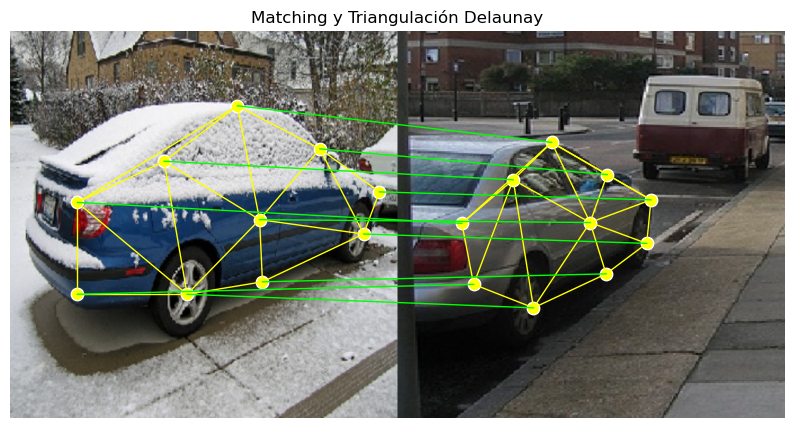

[2025-03-04 11:47:38] INFO: Visualizando par aleatorio para duck
[2025-03-04 11:47:38] INFO: Precisión del matching: 0.1


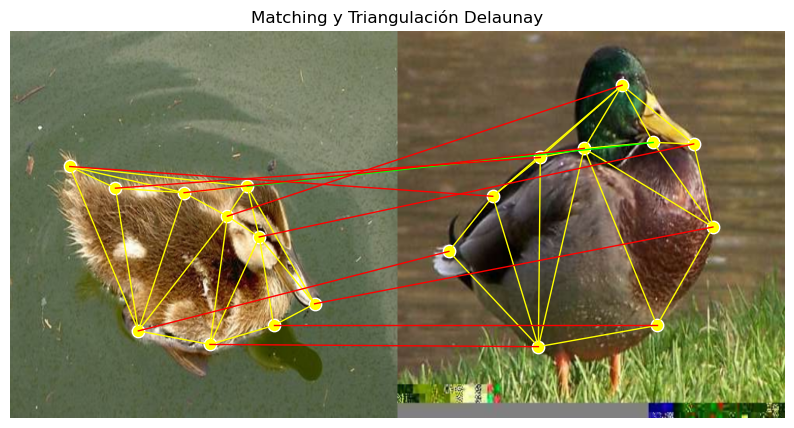

[2025-03-04 11:47:40] INFO: Visualizando par aleatorio para face
[2025-03-04 11:47:40] INFO: Precisión del matching: 1.0


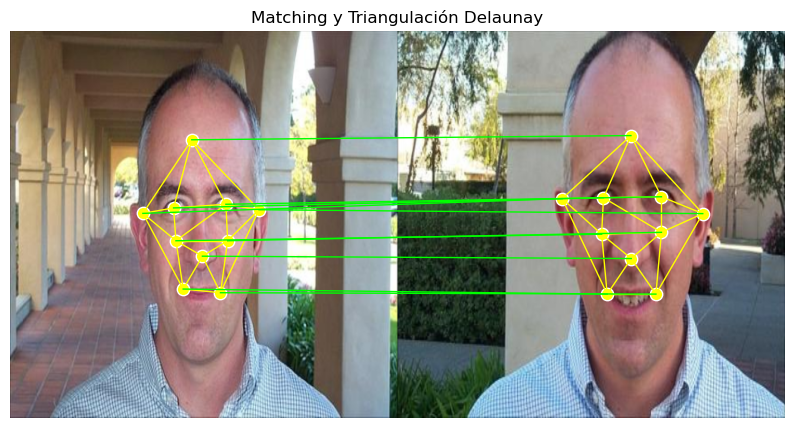

[2025-03-04 11:47:42] INFO: Visualizando par aleatorio para motorbike
[2025-03-04 11:47:42] INFO: Precisión del matching: 1.0


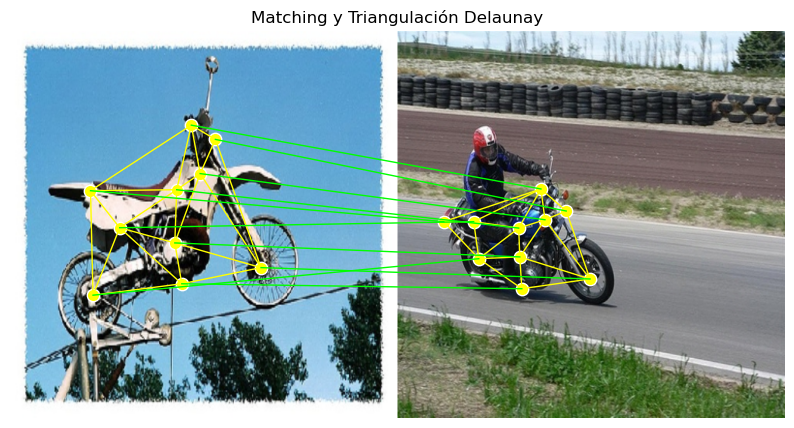

[2025-03-04 11:47:44] INFO: Visualizando par aleatorio para winebottle
[2025-03-04 11:47:44] INFO: Precisión del matching: 1.0


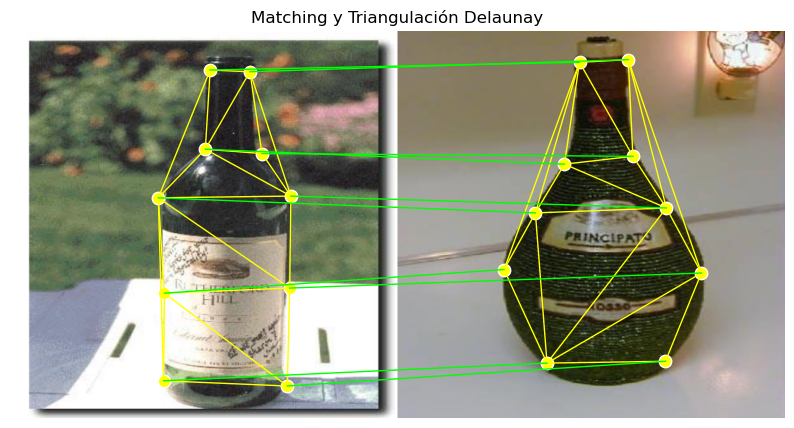

In [11]:
visualizacion_pares(dlf)

### Ejercicio 4, parte 2, experimento 1: Baseline Analysis
Este ejercicio trataba de hacer el matching solo con la distancia euclidea entre los keypoints de las imagenes, tal como lo habiamos hecho en la practica anterior. Para ello usé la función de `compute_cost_components` con el argumento `spacial_only=True` para calcular solo la distancia espacial entre los keypoints y obtener el matching correspondiente. No quería volver a escribir la función de la practica anterior, ya que no era necesario si lo planteaba bien con la función de esta practica.

In [12]:
def baseline_analisis(dlf):
    """
    Genera el matching igual que la practica anterior, pero reutiliando la función de esta practica de calcular los costos, usa `espacial_only=True` que le indica a la función que no calcule ni embeddings ni hitting times y solo calcule la distancia euclidiana entre los keypoints, va a devolver las mismas tres matrices de costos cost_spatial, cost_node2vec, cost_hitting pero con la diferencia que cost_node2vec y cost_hitting van a ser matrices de ceros. Después estas matrices se van a usar para calcular el matching pero con los pesos (1,0,0)
    """

    overall_results = []
    
    
    # Iterar sobre cada categoría en el dataset
    for cat_name, cat_df in dlf.items():
        precisions = []
        n = len(cat_df)
        num_pairs = 0
        
        for i in range(n - 1):
            for j in range(i + 1, n):
                row_a = cat_df.iloc[i]
                row_b = cat_df.iloc[j]
                
                # Cargar keypoints de cada fila
                kpts1, kpts2 = load_keypoints_from_row(row_a, row_b)
                
                # Calcular la triangulación de Delaunay para cada conjunto de keypoints
                adj1 = delaunay_triangulation(kpts1)
                adj2 = delaunay_triangulation(kpts2)
                
                # Calcular los componentes del costo y el matching avanzado
                cost_spatial, cost_node2vec, cost_hitting = compute_cost_components(
                    kpts1, kpts2, adj1, adj2, spacial_only=True)
                matching = compute_matching(cost_spatial, cost_node2vec, cost_hitting, 
                                            w_spatial=1, w_node2vec=0, w_hitting=0)
                
                # Evaluar la precisión del matching
                prec = evaluate_matching_precision(kpts1, matching)
                precisions.append(prec)
                num_pairs += 1

        
        # Calcular la precisión media y la desviación estándar para la categoría
        mean_prec = np.mean(precisions)
        std_prec = np.std(precisions)
        
        logger.info(f"Baseline Analysis - Category {cat_name.capitalize()}: Mean Accuracy = {mean_prec:.4f}, "f"Std Deviation = {std_prec:.4f}, Pairs Evaluated = {num_pairs}")
        
        overall_results.append({
            "Category": cat_name,
            "Mean_Accuracy": round(mean_prec, 4),
            "Std_Deviation": round(std_prec, 4),
            "Number_of_Pairs": num_pairs
        })
    
    # Crear un DataFrame con los resultados y exportarlos a CSV
    results_df = pd.DataFrame(overall_results)

    file = f"{resultados}baseline_results.csv"
    results_df.to_csv(file, index=False)
    logger.info(f"Baseline analysis results guardados en {file}")
    
    return results_df


In [13]:
baseline_rs = baseline_analisis(dlf)
baseline_rs

[2025-03-04 11:47:46] INFO: Baseline Analysis - Category Car: Mean Accuracy = 0.7118, Std Deviation = 0.3007, Pairs Evaluated = 780
[2025-03-04 11:47:48] INFO: Baseline Analysis - Category Duck: Mean Accuracy = 0.6753, Std Deviation = 0.2878, Pairs Evaluated = 1225
[2025-03-04 11:47:57] INFO: Baseline Analysis - Category Face: Mean Accuracy = 0.8452, Std Deviation = 0.1879, Pairs Evaluated = 5886
[2025-03-04 11:47:58] INFO: Baseline Analysis - Category Motorbike: Mean Accuracy = 0.8265, Std Deviation = 0.2302, Pairs Evaluated = 780
[2025-03-04 11:48:02] INFO: Baseline Analysis - Category Winebottle: Mean Accuracy = 0.8826, Std Deviation = 0.1792, Pairs Evaluated = 2145
[2025-03-04 11:48:02] INFO: Baseline analysis results guardados en ./results/baseline_results.csv


,Category,Mean_Accuracy,Std_Deviation,Number_of_Pairs
0,car,0.7118,0.3007,780
1,duck,0.6753,0.2878,1225
2,face,0.8452,0.1879,5886
3,motorbike,0.8265,0.2302,780
4,winebottle,0.8826,0.1792,2145


### Ejercicio 3 y Ejercicio 4, parte 2, experimento 2: Advanced Matching Analysis
Este ejercicio consiste en usar el algoritmo de matching avanzado que utiliza la distancia espacial, los embeddings de node2vec y los hitting times para obtener un matching (en teoria) más preciso. Para esto he usado las mismas funciones con los mismos parametros que en el ejercicio 2, pero con la diferencia de que esta vez he calculado la precisión para cada par de imagenes del dataset de 12 pares. 
- `pd` se que te vas a rallar Ahmed, pero yo me rallaba más, tardaba tanto que tuve que meterle una barrita de progreso para no quedarme dormido. Te la podría quitar si quieres, pero vaya, que simplemente primero se calcula el número de pares que voy a matchear, no se de mates ni de complejidades pero esa formula al menos se lo que hace, y luego simplemente se va sumando 1 a la barrita por cada par que se matchea. En los ultimos dos experimentos también la he puesto :)

In [14]:
def enhanced_matching_with_delaunay(dlf):
    """
    Realiza un análisis avanzado de matching combinando información espacial y estructural usando triangulación de Delaunay.
    
    Para cada categoría en el dataset (dlf) se:
      1. Iteran todos los pares de imágenes del dataset que se proporcione
      2. Se extraen todos los keypoints 
      3. Se calcula la triangulación de Delaunay para generar las matrices de adyacencia.
      4. Se obtienen las matrices de coste para cada par:
         - Distancia espacial (a partir de keypoints).
         - Distancia entre embeddings generados con node2vec. (a partir de la triangulación de Delaunay)
         - Diferencia en perfiles de hitting times. (a partir de la triangulación de Delaunay)
      5. Se combinan estos costes (ponderación: 40% espacial, 30% node2vec, 30% hitting times) y se aplica el algoritmo húngaro para obtener el matching 
      6. Finalmente, se evalúa la precisión del matching y se almacenan los resultados de precisión media y desviación estándar por categoría
    
    Los resultados (precisión media y desviación estándar) se registran por categoría y se exportan a "enhanced_results.csv".
    """
    overall_results = []  # Acumula los resultados por categoría
    total_iterations = sum((len(cat_df) * (len(cat_df) - 1)) // 2 for cat_df in dlf.values())
    pbar = tqdm(total=total_iterations, desc="Procesando pares")
    # Iterar sobre cada categoría en el dataset
    for cat_name, cat_df in dlf.items():
            
        enhanced_precisions = []  # Almacena la precisión de cada par de imágenes
        num_pairs = 0

        # Iterar sobre todas las combinaciones sin repetición de imágenes en la categoría
        for i in range(len(cat_df) - 1):
            for j in range(i + 1, len(cat_df)):
                row_a = cat_df.iloc[i]
                row_b = cat_df.iloc[j]

                # Extraer keypoints usando la función definida
                kpts1, kpts2 = load_keypoints_from_row(row_a, row_b)

                # Calcular la triangulación de Delaunay para generar las matrices de adyacencia
                adj1 = delaunay_triangulation(kpts1)
                adj2 = delaunay_triangulation(kpts2)

                # Calcular las componentes de coste (espacial, embeddings, hitting times)
                cost_spatial, cost_node2vec, cost_hitting = compute_cost_components(kpts1, kpts2, adj1, adj2)
                # Combinar los costes y obtener el matching óptimo
                matching = compute_matching(cost_spatial, cost_node2vec, cost_hitting, w_spatial=0.4, w_node2vec=0.3, w_hitting=0.3)

                # Evaluar la precisión del matching (ideal: diagonal)
                prec = evaluate_matching_precision(kpts1, matching)
                enhanced_precisions.append(prec)
                num_pairs += 1
                pbar.update(1)

        # Si se evaluó al menos un par, calcular la media y desviación; de lo contrario, asignar 0

        mean_prec = np.mean(enhanced_precisions)
        std_prec = np.std(enhanced_precisions)


        logger.info(f"Enhanced Matching - Category {cat_name.capitalize()}: Mean Accuracy = {mean_prec:.4f}, Std Deviation = {std_prec:.4f}, Pairs Evaluated = {num_pairs}")
        overall_results.append({
            "Category": cat_name,
            "Mean_Accuracy": round(mean_prec, 4),
            "Std_Deviation": round(std_prec, 4),
            "Number_of_Pairs": num_pairs
        })
    pbar.close()
    # Crear un DataFrame con los resultados globales y exportarlo a CSV
    results_df = pd.DataFrame(overall_results)
    file = f"{resultados}enhanced_results.csv"
    results_df.to_csv(file, index=False)
    logger.info(f"Enhanced matching results guardados en {file}")
    return results_df

In [15]:
delunay_spatial_rs = enhanced_matching_with_delaunay(dlf_12_pares)
delunay_spatial_rs

Procesando pares:   0%|          | 0/330 [00:00<?, ?it/s]

[2025-03-04 11:50:06] INFO: Enhanced Matching - Category Car: Mean Accuracy = 0.7561, Std Deviation = 0.3051, Pairs Evaluated = 66
[2025-03-04 11:52:07] INFO: Enhanced Matching - Category Duck: Mean Accuracy = 0.7848, Std Deviation = 0.2583, Pairs Evaluated = 66
[2025-03-04 11:53:51] INFO: Enhanced Matching - Category Face: Mean Accuracy = 0.9606, Std Deviation = 0.0868, Pairs Evaluated = 66
[2025-03-04 11:55:41] INFO: Enhanced Matching - Category Motorbike: Mean Accuracy = 0.8136, Std Deviation = 0.2480, Pairs Evaluated = 66
[2025-03-04 11:57:53] INFO: Enhanced Matching - Category Winebottle: Mean Accuracy = 0.8894, Std Deviation = 0.1281, Pairs Evaluated = 66
[2025-03-04 11:57:53] INFO: Enhanced matching results guardados en ./results/enhanced_results.csv


,Category,Mean_Accuracy,Std_Deviation,Number_of_Pairs
0,car,0.7561,0.3051,66
1,duck,0.7848,0.2583,66
2,face,0.9606,0.0868,66
3,motorbike,0.8136,0.2480,66
4,winebottle,0.8894,0.1281,66


### Ejercicio 4, parte 2, experimento 3: K-Nearest Neighbors Analysis
Para este ejercicio copié la función de knn de la practica de visualización de grafos parte 2 y la modifiqué para que en vez de devolver una lista de edges devolviera una matriz de adyacencia. Esta función la he usado para los embeddings de node2vec y para los hitting times de la misma forma que lo haciamos con Delaunay en el experimento 2. Hace lo mismo que haciamos en el ejercicio 2 pero con los embeddings y los hitting times calculados con KNN. Finalmente guarda los resultados obtenidos en distintos archivos por cada k que tenga en la lista de ks.

In [18]:
def knn_graph(kpts, k):
    """
    Construye un grafo usando k-Nearest Neighbors (sin distance_matrix) y devuelve la matriz de adyacencia.
    
    Parámetros:
        - kpts: np.array de shape (2, N) con las coordenadas de los keypoints.
        - k: número de vecinos a conectar.
    
    Devuelve:
        - A: Matriz de adyacencia de shape (N, N) donde A[i, j] = 1 indica que existe conexión entre los keypoints i y j.
    """
    pts = kpts.T  # Convertir a shape (N, 2)
    n = len(pts)
    # Inicializar la matriz de adyacencia con ceros
    A = np.zeros((n, n), dtype=int)
    
    # Calcular las distancias manualmente para cada punto
    for i in range(n):
        # 1. Calcular la distancia de pts[i] a todos los demás puntos
        distances = np.sqrt(np.sum((pts - pts[i])**2, axis=1))
        # 2. Excluir la distancia consigo mismo
        distances[i] = np.inf
        # 3. Obtener los índices de los k vecinos más cercanos
        knn_indices = np.argsort(distances)[:k]
        # 4. Marcar en la matriz la conexión con cada vecino seleccionado (simétrica)
        for j in knn_indices:
            A[i, j] = 1
            A[j, i] = 1  # Aseguramos la simetría del grafo (grafo no dirigido)
        
    return A



def enhanced_matching_with_knn(dlf, ks=(3,5,7)):
    """

    """
    # Total de iteraciones = (pares en todas las categorías) * (número de k's)
    total_iterations = len(ks) * sum((len(cat_df) * (len(cat_df) - 1)) // 2 for cat_df in dlf.values())
    pbar = tqdm(total=total_iterations, desc="Procesando pares")
    
    for k in ks:
        overall_results = []  # Reinicializar para cada valor de k
        for cat_name, cat_df in dlf.items():
            enhanced_precisions = []  # Almacena la precisión de cada par de imágenes
            num_pairs = 0

            # Iterar sobre todas las combinaciones sin repetición de imágenes en la categoría
            for i in range(len(cat_df) - 1):
                for j in range(i + 1, len(cat_df)):
                    row_a = cat_df.iloc[i]
                    row_b = cat_df.iloc[j]

                    # Extraer keypoints usando la función definida
                    kpts1, kpts2 = load_keypoints_from_row(row_a, row_b)

                    # Calcular el grafo k-NN usando la función knn_graph para ambos conjuntos
                    adj1 = knn_graph(kpts1, k)
                    adj2 = knn_graph(kpts2, k)

                    # Calcular las componentes de coste (espacial, node2vec, hitting times)
                    cost_spatial, cost_node2vec, cost_hitting = compute_cost_components(kpts1, kpts2, adj1, adj2)
                    
                    # Combinar los costes y obtener el matching óptimo
                    matching = compute_matching(cost_spatial, cost_node2vec, cost_hitting,
                                                w_spatial=0.4, w_node2vec=0.3, w_hitting=0.3)

                    # Evaluar la precisión del matching (ideal: diagonal)
                    prec = evaluate_matching_precision(kpts1, matching)
                    enhanced_precisions.append(prec)
                    num_pairs += 1
                    pbar.update(1)

            # Calcular la precisión media y desviación estándar para la categoría actual y k
            mean_prec = np.mean(enhanced_precisions)
            std_prec = np.std(enhanced_precisions)

            logger.info(f"Enhanced Matching knn{k} - Category {cat_name.capitalize()}: Mean Accuracy = {mean_prec:.4f}, Std Deviation = {std_prec:.4f}, Pairs Evaluated = {num_pairs}")
            overall_results.append({
                "Category": cat_name,
                "Mean_Accuracy": round(mean_prec, 4),
                "Std_Deviation": round(std_prec, 4),
                "Number_of_Pairs": num_pairs
            })
            
        # Crear un DataFrame con los resultados de la iteración actual de k y exportarlo a CSV
        results_df = pd.DataFrame(overall_results)
        file = f"{resultados}enhanced_knn{k}_results.csv"
        results_df.to_csv(file, index=False)
        logger.info(f"Enhanced matching results guardados en {file}")
        
    pbar.close()
    return results_df


In [ ]:
knn_rs = enhanced_matching_with_knn(dlf_12_pares)


[2025-03-04 12:02:00] INFO: Enhanced Matching knn3 - Category Car: Mean Accuracy = 0.6545, Std Deviation = 0.3271, Pairs Evaluated = 66
[2025-03-04 12:04:02] INFO: Enhanced Matching knn3 - Category Duck: Mean Accuracy = 0.7727, Std Deviation = 0.2694, Pairs Evaluated = 66
[2025-03-04 12:06:56] INFO: Enhanced Matching knn3 - Category Face: Mean Accuracy = 0.7871, Std Deviation = 0.2094, Pairs Evaluated = 66
[2025-03-04 12:08:21] INFO: Enhanced Matching knn3 - Category Motorbike: Mean Accuracy = 0.9030, Std Deviation = 0.1435, Pairs Evaluated = 66
[2025-03-04 12:10:23] INFO: Enhanced Matching knn3 - Category Winebottle: Mean Accuracy = 0.9303, Std Deviation = 0.1231, Pairs Evaluated = 66
[2025-03-04 12:12:01] INFO: Enhanced matching results guardados en ./results/enhanced_knn3_results.csv
[2025-03-04 12:16:42] INFO: Enhanced Matching knn5 - Category Car: Mean Accuracy = 0.6773, Std Deviation = 0.3237, Pairs Evaluated = 66
[2025-03-04 12:18:55] INFO: Enhanced Matching knn5 - Category Duc

### Ejercicio 4, parte 2, experimento 4: Weight Sensitivity Analysis
Este ejercicio trataba de probar las distintas sensibilidades de la combinación de los pesos de los componentes de coste en el matching avanzado. Aquí es donde cobra sentido la separación de las funciones de matching avanzado. Pese a usar una sola categoría del dataset, si tuviera que calcular los costes en cada combinación de pesos para cada par de imagenes, el tiempo de ejecución (que ya es excesivo) lo sería aún más. 7 veces más para ser exactos. Por eso he usado la función de `compute_cost_components` para calcular los costes una sola vez y luego simplemente he ido cambiando los pesos en la función de `compute_matching` para obtener los resultados de cada combinación de pesos. Tuve que implementar también una barrita de progreso para quedarme tranquilo, ya que pese a que separé las funciones, el tiempo de ejecución no bajaba de los 40 minutos. 

Para luego en el reporte comparar los resultados de forma más realista, metí en las combinaciones de pesos, el experimento de baseline (1,0,0) para comparar el baseline con los pesos de manera justa en este apartado.

In [ ]:
def weight_sensitivity_analysis_for_category(dlf, cat_name, weight_combinations=[(0.3, 0.3, 0.4),(0.3, 0.4, 0.3),(0.4, 0.3, 0.3),(0.5, 0.2, 0.3),(0.5, 0.3, 0.2),(0.6, 0.2, 0.2),(1,0,0)]):
    """
    Realiza un análisis de sensibilidad de pesos en el matching avanzado para una categoría seleccionada.
    
    Para cada combinación de pesos (espacial, node2vec, hitting time) se:
      - Iteran todos los pares de imágenes de la categoría.
      - Se extraen los keypoints y se calcula la triangulación de Delaunay para cada imagen.
      - Se obtienen las componentes de coste usando compute_cost_components (calculadas una única vez por par).
      - Se combina la información con los pesos especificados y se obtiene el matching óptimo 
        mediante compute_matching.
      - Se evalúa la precisión del matching usando evaluate_matching_precision.
    
    Los resultados (precisión media, desviación estándar y número de pares evaluados) se registran para cada
    combinación de pesos y se exportan en un CSV para la categoría.
    
    Parámetros:
      - dlf: Diccionario o DataFrame con los paths y keypoints de cada categoría.
      - cat_name: Nombre de la categoría a evaluar.
      - weight_combinations: Lista de tuplas con combinaciones de pesos (w_spatial, w_node2vec, w_hitting) a evaluar.
    
    Retorna:
      - results_df: DataFrame con las métricas para cada combinación de pesos evaluada.
    """
    cat_df = dlf[cat_name]
    overall_results = []
    
    # Inicializamos un diccionario con la key de cada combinación de pesos y una lista vacía para almacenar las precisiones, esto lo hacemos para no tener que calcular el matching con todas las combinaciones de pesos para cada par de imágenes
    precision_by_weight = {ws: [] for ws in weight_combinations}
    num_pairs = 0
    total_iterations = (len(cat_df) * (len(cat_df) - 1)) // 2

    pbar = tqdm(total=total_iterations, desc=f"Procesando pares de {cat_name}")
    
    
    for i in range(len(cat_df) - 1):
        for j in range(i + 1, len(cat_df)):
            row_a = cat_df.iloc[i]
            row_b = cat_df.iloc[j]
            
            # Extraer keypoints para ambos pares
            kpts1, kpts2 = load_keypoints_from_row(row_a, row_b)
            
            # Calcular triangulación de Delaunay para generar las matrices de adyacencia
            adj1 = delaunay_triangulation(kpts1)
            adj2 = delaunay_triangulation(kpts2)
            
            # Obtener las componentes de coste una sola vez para el par
            cost_spatial, cost_node2vec, cost_hitting = compute_cost_components(kpts1, kpts2, adj1, adj2)
            
            # Para cada combinación de pesos, calcular el matching y evaluar la precisión
            for ws in weight_combinations:
                w_spatial, w_node2vec, w_hitting = ws
                if ws == (1, 0, 0):
                    cost_spatial, cost_node2vec, cost_hitting = compute_cost_components(kpts1, kpts2, adj1, adj2, spacial_only=True)
                matching= compute_matching(cost_spatial, cost_node2vec, cost_hitting, w_spatial=w_spatial, w_node2vec=w_node2vec, w_hitting=w_hitting)
                prec = evaluate_matching_precision(kpts1, matching)
                precision_by_weight[ws].append(prec)
            
            num_pairs += 1
            pbar.update(1)
    pbar.close()

    # Calcular la precisión media y desviación estándar para cada combinación de pesos
    for ws in weight_combinations:
        precs = precision_by_weight[ws]
        mean_prec = np.mean(precs) 
        std_prec = np.std(precs) 
        
        overall_results.append({
            "Weight_Combination": f"({ws[0]}, {ws[1]}, {ws[2]})",
            "Mean_Accuracy": round(mean_prec, 4),
            "Std_Deviation": round(std_prec, 4),
            "Number_of_Pairs": num_pairs
        })
        logger.info(f"Weight Combination ({ws[0]}, {ws[1]}, {ws[2]}): Mean Accuracy = {mean_prec:.4f}, Std Deviation = {std_prec:.4f}, Pairs Evaluated = {num_pairs}")
    
    # Crear un DataFrame con los resultados y exportarlo a CSV.
    # Se asume que 'resultados' es una variable global con el path donde guardar los CSV;
    # en caso contrario, se utiliza el nombre de la categoría.
    filename = f"{resultados}{cat_name}_weight_sensitivity_results.csv" if 'resultados' in globals() else f"{cat_name}_weight_sensitivity_results.csv"
    results_df = pd.DataFrame(overall_results)
    results_df.to_csv(filename, index=False)
    logger.info(f"Weight sensitivity analysis results guardados en {filename}")
    
    return results_df


In [ ]:
sensitivity_rs = weight_sensitivity_analysis_for_category(dlf,'duck')
sensitivity_rs

Procesando pares de duck:   0%|          | 0/1225 [00:00<?, ?it/s]

[2025-03-03 21:30:43] INFO: Weight Combination (0.3, 0.3, 0.4): Mean Accuracy = 0.7427, Std Deviation = 0.2801, Pairs Evaluated = 1225
[2025-03-03 21:30:43] INFO: Weight Combination (0.3, 0.4, 0.3): Mean Accuracy = 0.7412, Std Deviation = 0.2831, Pairs Evaluated = 1225
[2025-03-03 21:30:43] INFO: Weight Combination (0.4, 0.3, 0.3): Mean Accuracy = 0.7389, Std Deviation = 0.2842, Pairs Evaluated = 1225
[2025-03-03 21:30:43] INFO: Weight Combination (0.5, 0.2, 0.3): Mean Accuracy = 0.7353, Std Deviation = 0.2859, Pairs Evaluated = 1225
[2025-03-03 21:30:43] INFO: Weight Combination (0.5, 0.3, 0.2): Mean Accuracy = 0.7293, Std Deviation = 0.2851, Pairs Evaluated = 1225
[2025-03-03 21:30:43] INFO: Weight Combination (0.6, 0.2, 0.2): Mean Accuracy = 0.7268, Std Deviation = 0.2858, Pairs Evaluated = 1225
[2025-03-03 21:30:43] INFO: Weight Combination (1, 0, 0): Mean Accuracy = 0.6753, Std Deviation = 0.2878, Pairs Evaluated = 1225
[2025-03-03 21:30:43] INFO: Weight sensitivity analysis resul

,Weight_Combination,Mean_Accuracy,Std_Deviation,Number_of_Pairs
0,"(0.3, 0.3, 0.4)",0.7427,0.2801,1225
1,"(0.3, 0.4, 0.3)",0.7412,0.2831,1225
2,"(0.4, 0.3, 0.3)",0.7389,0.2842,1225
3,"(0.5, 0.2, 0.3)",0.7353,0.2859,1225
4,"(0.5, 0.3, 0.2)",0.7293,0.2851,1225
5,"(0.6, 0.2, 0.2)",0.7268,0.2858,1225
6,"(1, 0, 0)",0.6753,0.2878,1225
